<a href="https://colab.research.google.com/github/janerikhy/geoDjango/blob/master/ImageClassificationTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Extracting the dataset from Google Drive
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
BASE_DIR = os.path.abspath('')
DATA_DIR = os.path.join(BASE_DIR, 'gdrive', 'MyDrive', 'ML_Dataset')
TEST_DIR = os.path.join(BASE_DIR, 'gdrive', 'MyDrive', 'TestData')
test_imgs = os.listdir(TEST_DIR)
test_imgs

['Pacific Oyster', 'Blue Mussel']

In [ ]:
os.listdir(DATA_DIR)

['Blue Mussel', 'Pacific Oyster']

In [ ]:
# Load the data from directory

IMG_SIZE = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(DATA_DIR, validation_split=0.2, subset='training', seed=123, image_size=(IMG_SIZE, IMG_SIZE), batch_size=32)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(DATA_DIR, validation_split=0.2, subset='validation', seed=123, image_size=(IMG_SIZE, IMG_SIZE), batch_size=32)

Found 2410 files belonging to 2 classes.
Using 1928 files for training.
Found 2410 files belonging to 2 classes.
Using 482 files for validation.


In [ ]:
# 

IMG_SIZE = (224, 224)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

(32, 1280)
(32, 2)


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [ ]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(val_ds)

16/16 [==============================] - 32s 1s/step - loss: 0.7542 - accuracy: 0.5830


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/15
61/61 [==============================] - 151s 2s/step - loss: 0.4316 - accuracy: 0.8273 - val_loss: 0.3468 - val_accuracy: 0.9046
Epoch 2/15
61/61 [==============================] - 147s 2s/step - loss: 0.2935 - accuracy: 0.9077 - val_loss: 0.2632 - val_accuracy: 0.9108
Epoch 3/15
61/61 [==============================] - 154s 2s/step - loss: 0.2281 - accuracy: 0.9227 - val_loss: 0.1983 - val_accuracy: 0.9191
Epoch 4/15
61/61 [==============================] - 150s 2s/step - loss: 0.1806 - accuracy: 0.9336 - val_loss: 0.1515 - val_accuracy: 0.9295
Epoch 5/15
61/61 [==============================] - 149s 2s/step - loss: 0.1551 - accuracy: 0.9414 - val_loss: 0.1200 - val_accuracy: 0.9544
Epoch 6/15
61/61 [==============================] - 148s 2s/step - loss: 0.1234 - accuracy: 0.9580 - val_loss: 0.0981 - val_accuracy: 0.9564
Epoch 7/15
61/61 [==============================] - 158s 2s/step - loss: 0.1072 - accuracy: 0.9632 - val_loss: 0.0825 - val_accuracy: 0.9606
Epoch 8/15
61

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR, image_size=IMG_SIZE)
class_names = test_dataset.class_names

Found 2 files belonging to 2 classes.


Predictions:
 [1 0 0 1]
Labels:
 [0 1]


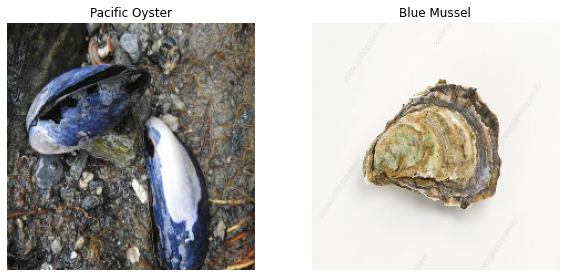

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)


print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(2):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
loss, acc = model.evaluate(test_dataset)
model.save(os.path.join(BASE_DIR, 'gdrive', 'MyDrive', 'ML_MODEL'), 'TransferModel')

1/1 [==============================] - 0s 112ms/step - loss: 0.1578 - accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ML_MODEL/assets


In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [ ]:
imagenet_labels

In [ ]:
print(json.dumps(imagenet_labels))

In [ ]:
img = tf.keras.preprocessing.image.load_img(os.path.join(TEST_DIR, 'Blue Mussel', os.listdir(os.path.join(TEST_DIR, 'Blue Mussel'))[0]), target_size=(224, 224))

In [ ]:
img_array = np.array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)], 100*np.max(score))


Blue Mussel 84.76137518882751


In [ ]:
model.save(os.path.join(BASE_DIR, 'gdrive', 'MyDrive', 'ML_MODEL', 'transfer learning model'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ML_MODEL/transfer learning model/assets
